**Designing an mRNA vaccine against SARS-CoV-2 variants**


In [1]:
!git clone https://github.com/NAalytics/Assemblies-of-putative-SARS-CoV2-spike-encoding-mRNA-sequences-for-vaccines-BNT-162b2-and-mRNA-1273.git

Cloning into 'Assemblies-of-putative-SARS-CoV2-spike-encoding-mRNA-sequences-for-vaccines-BNT-162b2-and-mRNA-1273'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 64 (delta 22), reused 12 (delta 12), pack-reused 38
Unpacking objects: 100% (64/64), done.


In [2]:
!pip install BioPython

     |████████████████████████████████| 2.3 MB 6.7 MB/s 


In [3]:
# imports
from random import randint
from collections import Counter
from copy import copy
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import pandas as pd

from Bio import SeqIO, Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import pairwise2

In [4]:
# CONSTS
INIT_CODON = 'AUG'
TERM_CODONS = ['UAG', 'UAA', 'UGA']
VACCINE_FILES = 'Assemblies-of-putative-SARS-CoV2-spike-encoding-mRNA-sequences-for-vaccines-BNT-162b2-and-mRNA-1273/Figure1Figure2_032321.fasta'
WUHAN_NCBI_ID = 'NC_045512.2'
BA1_NCBI_ID = 'ON326855.1'
BA2_NCBI_ID = 'ON260467.1'

# Vaccines

:Create a function that takes mRNA as an input and returns the translated coding region (Hint 1: you need to find the initiation codon and the stop codon. Hint 2: use BioPython!).

In [5]:
def read_file_records(file_name: str) -> List[SeqRecord]:
    records =[]
    with open(file_name) as file:
        for record in SeqIO.parse(file, "fasta"):
            records.append(record)
    return records

In [6]:
class RecordController:
    init_idx, term_idx, term_codon = None, None, None
    dna_spike, rna_spike, protein = None, None, None
    gc = None

    def __init__(self, name, record):
        self.name: str = name
        self.record: SeqRecord = record
        self.dna: Seq = record.seq
        self.rna: Seq = record.seq.transcribe()

    @staticmethod
    def find_termination_codon(seq_from_init: Seq) -> Tuple[int, str]:
        for i in range(0, len(seq_from_init) - 3, 3):
            if seq_from_init[i:i + 3] in TERM_CODONS:
                return i, seq_from_init[i:i + 3]

    def find_spike(self):
        self.init_idx, self.term_idx, self.term_codon = self._find_rna_spike()
        self.calc_spike()
    
    def _find_rna_spike(self) -> Tuple[int, int, Seq]:
        init_idx = self.rna.find(INIT_CODON)
        init_to_term, term_codon = self.find_termination_codon(self.rna[init_idx:])
        term_idx = init_idx + init_to_term
        return init_idx, term_idx, term_codon

    def calc_spike(self):
        self.dna_spike = self.dna[self.init_idx:self.term_idx + 3]
        self.rna_spike = self.rna[self.init_idx:self.term_idx + 3]
        self.protein = self.rna_spike.translate()
        self.gc = GC(self.dna_spike)

    def print_info(self):
        print(f"____{self.name}____")
        print(f"The initiation codon is at location: {self.init_idx}")
        print(f"The termination codon is {self.term_codon} at location: {self.term_idx}")
        print(f"The length of the mRNA coding region is {len(self.rna_spike)}")
        print(f"The length of the protein is {len(self.protein)}")
        print(f"The {self.name} protein: {self.protein}\n")
    
    def create_histograms(self):
        amino_acids = Counter(self.protein)
        df = pd.DataFrame.from_dict(amino_acids, orient='index').reset_index()
        df.plot.bar(x="index", stacked=True, legend=None)
        plt.xlabel = 'Amino Acids in our protein'
        plt.ylabel = 'Count'
        plt.show()

        codons = [self.rna_spike[i:i+3] for i in range(0, len(self.rna_spike), 3)]
        count_codons = Counter(codons)
        df = pd.DataFrame(columns=count_codons.keys(), index=amino_acids.keys())
        for codon, count in count_codons.items():
            acid = codon.translate()
            df.at[acid, codon] = count
        df.plot.bar(stacked=True)
        ax = plt.subplot(111)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 4.5})
        plt.xlabel = 'Amino Acids in our protein'
        plt.ylabel = 'Count'
        plt.show()


In [7]:
records = read_file_records(VACCINE_FILES)

pfizer = RecordController('Pfizer', records[0])
pfizer.find_spike()
pfizer.print_info()

moderna = RecordController('Moderna', records[1])
moderna.find_spike()
moderna.print_info()

____Pfizer____
The initiation codon is at location: 54
The termination codon is UGA at location: 3873
The length of the mRNA coding region is 3822
The length of the protein is 1274
The Pfizer protein: MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGG

What’s the position of the initiation codon (“AUG”)?
**Pfizer - 54, Moderna - 57**

What’s the position of the termination codon?
**Pfizer - 3873, Moderna - 3876**

What sequence did each company use for the stop codon?
**Pfizer - 'UGA', Moderna - 'UGA'**

Please suggest another stop codon sequence.
**'UAA', 'UAG'**

How would you call the area between the first nucleotide and the “AUG” site?
**5-Prime UTR (un-translated region)**

How would you call the area between the termination codon and the last nucleotide?
**3-prime UTR**

Using your function, translate the coding area into protein. What’s the length of each coding sequence?
**Pfizer - 1274, Moderna - 1274**

Are the coding regions of the vaccines identical in the protein level?
**Yes**

Are the coding regions of the vaccines identical in the nucleotide level?
**No**

Create a histogram of amino-acids usage for the Pfizer vaccine

Create the same histogram but color each codon within the amino-acid (i.e. create a stacked histogram)

___Pfizer___


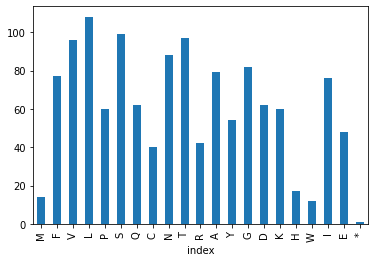

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


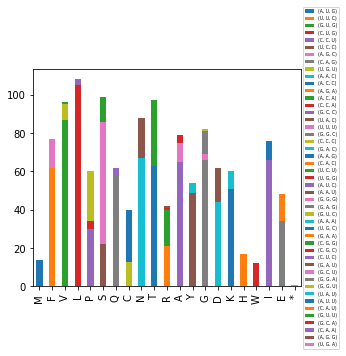

___Moderna___


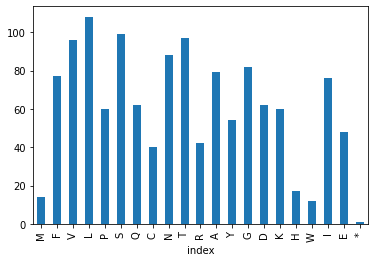

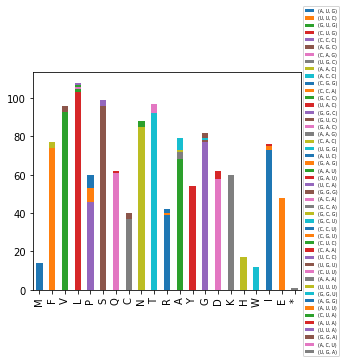

In [ ]:
print("___Pfizer___")
pfizer.create_histograms()

print("___Moderna___")
moderna.create_histograms()

# Wuhan Strain

In [8]:
def get_ncbi_record(id: str) -> SeqRecord:
    handle = Entrez.efetch(db='nucleotide', id=id, rettype='fasta', email="test@gmail.com")
    return SeqIO.read(handle, "fasta")

def create_look_up_table(strain: Seq, vaccine: Seq) -> Dict:
    """ Returns map from strain codons to vaccine codons"""
    assert len(strain) >= len(vaccine)
    lookup_map = {}
    for i in range(0, len(strain) - 3, 3):
        strain_codon = strain[i:i+3]
        vaccine_codon = vaccine[i:i+3]

        if lookup_map.get(strain_codon):
            if vaccine_codon not in lookup_map[strain_codon]:
                lookup_map[strain_codon].append(vaccine_codon)
        else:
            lookup_map[strain_codon] = [vaccine_codon]

    return lookup_map

def compare_GC(rec_a: RecordController, rec_b: RecordController):
    print(f'GC of {rec_a.name}: {round(rec_a.gc, 3)}, GC of {rec_b.name}: {round(rec_b.gc, 3)}')

def compare_sequences(seq_a: Seq, seq_b: Seq):
    alignments = pairwise2.align.globalxx(seq_a, seq_b)
    print(pairwise2.format_alignment(*alignments[0]))
    index = alignments[0][1].find('-')
    differences = int(len(seq_a) - alignments[0].score)
    print(f"There are {differences} differences, first difference at index {index}")

What’s the length of the Wuhan strain genome? **29903**


In [9]:
wuhan_rec = get_ncbi_record(WUHAN_NCBI_ID)
wuhan = RecordController("Wuhan strain", wuhan_rec)
print(f'The length of the wuhan strain is {len(wuhan.dna)}')

The length of the wuhan strain is 29903


Report the nucleotide sequence of the Spike region of the Wuhan strain from the initiation codon to the termination codon (hint: use the information in the NCBI website about the starting and stopping position of Spike).

In [10]:
wuhan.init_idx, wuhan.term_idx = 21562, 25384
wuhan.calc_spike()
print(f'{wuhan.name} spike: {wuhan.dna_spike}')

Wuhan strain spike: ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGT

Report the GC content of the Spike region of the Wuhan strain and compare it to the GC content of the Spike region of the Pfizer vaccine.

In [11]:
compare_GC(wuhan, pfizer)

GC of Wuhan strain: 37.333, GC of Pfizer: 56.986


Translate the sequence into amino acids and report the sequence of the protein

In [12]:
wuhan.print_info()

____Wuhan strain____
The initiation codon is at location: 21562
The termination codon is None at location: 25384
The length of the mRNA coding region is 3825
The length of the protein is 1275
The Wuhan strain protein: MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVF

Compare between the Spike region of the Pfizer vaccine to the Spike of the Wuhan strain in the protein level. Are there any differences and where?
Bonus: explain the differences!

In [ ]:
compare_sequences(pfizer.protein, wuhan.protein)

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPP--EAEVQIDRLIT

**We found 2 differences at index 985, Pfizer vaccine has "PP" amino-acids, 
while Wuhan strain has "KV" amino-acids**

For the amino acids that appear in the vaccine and the Wuhan strain, create a look-up table that maps between the Wuhan strain codon to the Pfizer codon

In [13]:
wuhan_to_pfizer_codon_map = create_look_up_table(wuhan.dna_spike, pfizer.dna_spike)
wuhan_to_pfizer_codon_map

{Seq('AAA'): [Seq('AAG'), Seq('AAA'), Seq('CCT')],
 Seq('AAC'): [Seq('AAC'), Seq('AAT')],
 Seq('AAG'): [Seq('AAG'), Seq('AAA')],
 Seq('AAT'): [Seq('AAC'), Seq('AAT')],
 Seq('ACA'): [Seq('ACC'), Seq('ACA')],
 Seq('ACC'): [Seq('ACC'), Seq('ACA')],
 Seq('ACG'): [Seq('ACC')],
 Seq('ACT'): [Seq('ACA'), Seq('ACC')],
 Seq('AGA'): [Seq('AGA'), Seq('CGG'), Seq('AGG')],
 Seq('AGC'): [Seq('AGC'), Seq('TCC')],
 Seq('AGG'): [Seq('AGA'), Seq('CGC'), Seq('CGG')],
 Seq('AGT'): [Seq('AGC'), Seq('TCT')],
 Seq('ATA'): [Seq('ATC'), Seq('ATT')],
 Seq('ATC'): [Seq('ATC'), Seq('ATT')],
 Seq('ATG'): [Seq('ATG')],
 Seq('ATT'): [Seq('ATC'), Seq('ATT')],
 Seq('CAA'): [Seq('CAG'), Seq('CAA')],
 Seq('CAC'): [Seq('CAC'), Seq('CAT')],
 Seq('CAG'): [Seq('CAG')],
 Seq('CAT'): [Seq('CAC'), Seq('CAT')],
 Seq('CCA'): [Seq('CCT'), Seq('CCC')],
 Seq('CCC'): [Seq('CCT'), Seq('CCC')],
 Seq('CCT'): [Seq('CCA'), Seq('CCC'), Seq('CCT')],
 Seq('CGC'): [Seq('CGG')],
 Seq('CGG'): [Seq('CGG'), Seq('AGA')],
 Seq('CGT'): [Seq('AGA'),

Can you deduce any rule about the look-up table that Pfizer uses internally?
Bonus: explain the differences!

**The lookup table maps non-GC codons to GC codons thus increasing the GC content in the vaccine. This will increase the stability of the vaccine while maintaining the same amino-acid structure.**

# Variants

Develop a method to extract the Spike sequence of one of the entries, translate, and report the protein sequence (hint: the BA.2 spike is not very different than the Wuhan strain and must start with AUG).

In [14]:
ba2_rec = get_ncbi_record(BA2_NCBI_ID)
ba2 = RecordController("BA2", ba2_rec)
# since the variants are similar we could deduce:
ba2.init_idx = ba2.dna.find(wuhan.dna_spike[:50])
ba2.term_idx, ba2.term_codon = ba2.find_termination_codon(ba2.rna[ba2.init_idx:])
ba2.term_idx += ba2.init_idx
ba2.calc_spike()
ba2.print_info()

____BA2____
The initiation codon is at location: 21550
The termination codon is UAA at location: 25360
The length of the mRNA coding region is 3813
The length of the protein is 1271
The BA2 protein: MFVFLVLLPLVSSQCVNLITRTQSYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLGRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFAFKCYGVSPTKLNDLCFTNVYADSFVIRGNEVSQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYGFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQ


Use everything you learned so far, including the look up table of Pfizer and the addition of special nucleotides to design a BA.2 mRNA vaccine. Don’t forget the add the 5’UTR and 3’UTR. Report the vaccine sequence.


In [15]:
def replace_specific_codons(seq: Seq, idx: int, x_len: int, insert_codons: Seq) -> Seq:
    return seq[:idx] + insert_codons + seq[idx + x_len:]
    
def increase_gc_content(dna_spike: Seq, lookup_table: Dict[Seq, List[Seq]]) -> Seq:
    new_dna_spike = Seq('')
    for i in range(0, len(dna_spike) - 3, 3):
        codon_list = lookup_table.get(dna_spike[i:i+3], [dna_spike[i:i+3]])
        new_dna_spike += codon_list[randint(0, len(codon_list) - 1)]
    return new_dna_spike

def replace_spike(vaccine: RecordController, new_spike: Seq):
    utr5 = vaccine.dna[:vaccine.init_idx]
    utr3 = vaccine.dna[vaccine.term_idx + 3:]
    vaccine.dna = utr5 + new_spike + utr3
    vaccine.rna = vaccine.dna.transcribe()
    vaccine.calc_spike()

In [16]:
ba2_vaccine = copy(ba2)
ba2_vaccine.name = "BA.2 Vaccine"

codon_idx = (ba2_vaccine.protein.find('LDKV') + 2) * 3  # "KV" is removed, "LDKV" to find unique sequence
new_spike = replace_specific_codons(ba2_vaccine.dna_spike, codon_idx, 6, Seq('CCACCA'))  # "CCACCA" are the inserted codons
new_spike = increase_gc_content(new_spike, wuhan_to_pfizer_codon_map)
replace_spike(ba2_vaccine, new_spike)

print(f"The new {ba2_vaccine.name} is {ba2_vaccine.dna}")
compare_GC(ba2, ba2_vaccine)

The new BA.2 Vaccine is AAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTTGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGGTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATT

Repeat the same process for the BA.1 genomes. How many amino-acid differences are there between the genomes of BA.1 and BA.2?  **21 differences were found**

In [17]:
ba1_rec = get_ncbi_record(BA1_NCBI_ID)
ba1 = RecordController("BA1", ba1_rec)
# since the variants are similar we could deduce:
ba1.init_idx = ba1.dna.find(wuhan.dna_spike[:50])
ba1.term_idx, ba1.term_codon = ba1.find_termination_codon(ba1.rna[ba1.init_idx:])
ba1.term_idx += ba1.init_idx
ba1.calc_spike()
ba1.print_info()

compare_sequences(ba1.protein, ba2.protein)

____BA1____
The initiation codon is at location: 21500
The termination codon is UAA at location: 25310
The length of the mRNA coding region is 3813
The length of the protein is 1271
The BA1 protein: MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHVISGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIIVREPEDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQ

In [18]:
ba1_vaccine = copy(ba1)
ba1_vaccine.name = "BA.1 Vaccine"

codon_idx = (ba1_vaccine.protein.find('LDKV') + 2) * 3  # "KV" is removed, "LDKV" to find unique sequence
new_spike = replace_specific_codons(ba1_vaccine.dna_spike, codon_idx, 6, Seq('CCACCA'))  # "CCACCA" are the inserted codons
new_spike = increase_gc_content(new_spike, wuhan_to_pfizer_codon_map)
replace_spike(ba1_vaccine, new_spike)

print(f"The new {ba1_vaccine.name} is {ba1_vaccine.dna}")
compare_GC(ba1, ba1_vaccine)

The new BA.1 Vaccine is TTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACC